In [1]:
import time
import numpy as np
import networkx as nx
from utils.dotdict import dotdict
import matplotlib.pyplot as plt
from numba import jit

import itertools
import multiprocessing

from utils.graph_generator import get_graph

from scripts.awareness.agent_country import Agent_Country

args = dotdict({
    "logfile": "/tmp/temp.log",
    "plot": False,
    "max_iteration": 1000,
    "beta_super":0.0,
    "xi": 1,
    "p_teleport":0.0,
    "MAX_E_TIME":10,
    "MAX_I_TIME":10,
    "super_infected_agents": [],
    "p_super": 0.0,
    "awM": None,
    "awR": -1,
    "random_seed":0,
    "CPU_cores":4,
    "simnum":10,
})


In [2]:
def run(args, beta, gamma, n, awM, callback , **kwds):
    args = dotdict(args)
    graph = get_graph("grid", {"n": n*n, "N": -1, "d": 4})
    args["I_time"]=int(1/gamma)
    args["infected_agents"]=[n//2+(n//2)*n]
    args["beta"]=beta
    args["gamma"]=gamma
    args["awM"] = awM

    country = Agent_Country(args, graph)
    history,merged = country.run_fast(0, args.infected_agents, simnum=args["simnum"], callback=callback, **kwds)
    return history

def multi_run(args, betas, gammas, ns, awMs, callback, **kwargs):
    temp_res = {}
    pool = multiprocessing.Pool(processes=args.CPU_cores)

    for (beta, gamma), n, awM in itertools.product(zip(betas, gammas), ns, awMs):
        temp_res[(beta, gamma, n, awM)]=pool.apply_async(run, args=(dict(args), beta, gamma, n, awM, callback), kwds=kwargs)

    pool.close()
    pool.join()

    res = {}
    for params, hist in temp_res.items():
        res[params] = hist.get()

    return res

def measure1(args, betas, gammas, ns, awMs, xs, plot_args, **kwargs):
    @jit(nopython=True)
    def get_mean(hist, max_iter):
        res = np.zeros(len(hist))
        for i in range(len(hist)):
            res[i]=np.mean(hist[i,max_iter//2:,2])
        return res

    
    for awR in [0.2,2.0]:
        for th in [0.1,0.2,0.5]:
            args['awR']=awR
            kwargs['sigmoid_th']=th
            res = multi_run(args, betas, gammas, ns, awMs, get_mean, **kwargs)
            res_y = {p: np.mean(hist) for p,hist in res.items()}
            res_err = {p: np.std(hist) for p,hist in res.items()}

            ys = [res_y[(beta,gamma,n,awM)] for (beta,gamma),n,awM in itertools.product(zip(betas,gammas),ns,awMs)]
            y_err = [res_err[(beta,gamma,n,awM)] for (beta,gamma),n,awM in itertools.product(zip(betas,gammas),ns,awMs)]


            # === Plot ===
            xs = np.array(xs)
            plt.errorbar(xs,ys, yerr=y_err, label=f"th: {th}, awR: {awR}")

    if("limits" not in plot_args):
        a,b = None, None
    else:
        a,b = plot_args["limits"]
    plt.title(plot_args["title"])
    plt.xlabel(plot_args["xlabel"])
    plt.ylabel(plot_args["ylabel"])
    plt.legend()
    
def measure2(args, betas, gammas, ns, awMs, xs, plot_args, **kwargs):
    @jit(nopython=True)
    def get_mean(hist, max_iter):
        res = np.zeros(len(hist))
        for i in range(len(hist)):
            res[i]=np.mean(hist[i,max_iter//2:,2])
        return res

    
    for awR in [0.1,0.2,0.5]:
        args["awR"] = awR
        res = multi_run(args, betas, gammas, ns, awMs, get_mean, **kwargs)
        res_y = {p: np.mean(hist) for p,hist in res.items()}
        res_err = {p: np.std(hist) for p,hist in res.items()}

        ys = [res_y[(beta,gamma,n,awM)] for (beta,gamma),n,awM in itertools.product(zip(betas,gammas),ns,awMs)]
        y_err = [res_err[(beta,gamma,n,awM)] for (beta,gamma),n,awM in itertools.product(zip(betas,gammas),ns,awMs)]
        
        
        # === Plot ===
        xs = np.array(xs)
        plt.errorbar(xs,ys, yerr=y_err, label=f"awR: {awR}")

    if("limits" not in plot_args):
        a,b = None, None
    else:
        a,b = plot_args["limits"]
    plt.title(plot_args["title"])
    plt.xlabel(plot_args["xlabel"])
    plt.ylabel(plot_args["ylabel"])
    plt.legend()

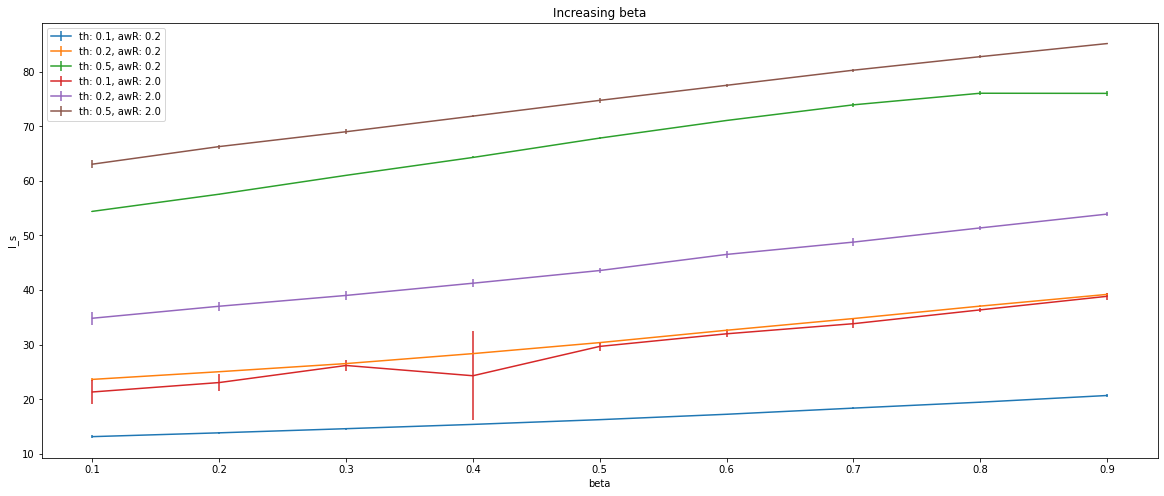

CPU times: user 553 ms, sys: 584 ms, total: 1.14 s
Wall time: 2min 38s


In [3]:
%%time

plt.figure(figsize=(20,8))
# === 1 ===
betas = np.array(range(1,10))/10
gammas = betas/2
args["awR"]=2
measure1(args, betas, gammas, [10], [0.1],
        xs = betas,
        plot_args={
            "xlabel":"beta",
            "ylabel":"I_s",
            "title":"Increasing beta",
            #"limits":(2,None)},    
        },
        **{'sigmoid':1.0, 'sigmoid_speed':10.0, 'sigmoid_th':0.1})
plt.show()

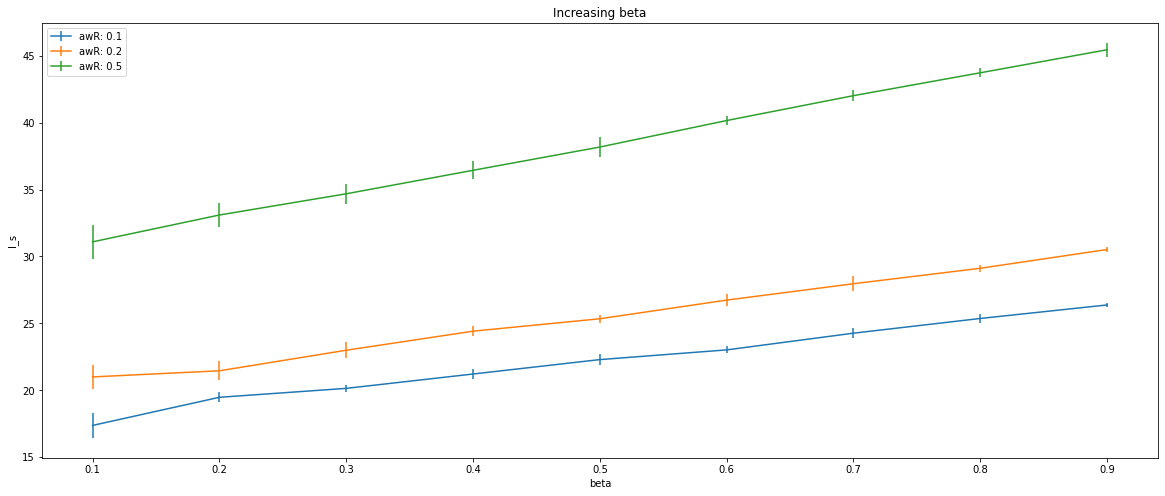

In [4]:

plt.figure(figsize=(20,8))
# === 1 ===
betas = np.array(range(1,10))/10
gammas = betas/2
args["awR"]=2
measure2(args, betas, gammas, [10], [0.1],
        xs = betas,
        plot_args={
            "xlabel":"beta",
            "ylabel":"I_s",
            "title":"Increasing beta",
            #"limits":(2,None)},    
        },
        **{})
plt.show()